In [126]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:

import argparse, os, sys, datetime
from omegaconf import OmegaConf
from transformers import logging as transf_logging
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.trainer import Trainer
import torch
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils.utils import instantiate_from_config
from utils.utils_train import get_trainer_callbacks, get_trainer_logger, get_trainer_strategy
from utils.utils_train import set_logger, init_workspace, load_checkpoints, load_checkpoints_unet




def get_parser(**parser_kwargs):
    parser = argparse.ArgumentParser(**parser_kwargs)

    parser.add_argument("--seed", "-s", type=int, default=20250101, help="seed for seed_everything")
    # parser.add_argument("--seed", "-s", type=int, default=0, help="seed for seed_everything")


    parser.add_argument("--name", "-n", type=str, default="", help="experiment name, as saving folder")

    parser.add_argument("--base", "-b", nargs="*", metavar="base_config.yaml", help="paths to base configs. Loaded from left-to-right. "
                            "Parameters can be overwritten or added with command-line options of the form `--key value`.", default=list())
    
    parser.add_argument("--train", "-t", action='store_true', default=False, help='train')
    parser.add_argument("--val", "-v", action='store_true', default=False, help='val')
    parser.add_argument("--test", action='store_true', default=False, help='test')

    parser.add_argument("--logdir", "-l", type=str, default="logs", help="directory for logging dat shit")
    parser.add_argument("--auto_resume", action='store_true', default=False, help="resume from full-info checkpoint")
    parser.add_argument("--auto_resume_weight_only", action='store_true', default=False, help="resume from weight-only checkpoint")
    parser.add_argument("--debug", "-d", action='store_true', default=False, help="enable post-mortem debugging")
    

    return parser
    
def get_nondefault_trainer_args(args):
    parser = argparse.ArgumentParser()
    parser = Trainer.add_argparse_args(parser)
    default_trainer_args = parser.parse_args([])
    return sorted(k for k in vars(default_trainer_args) if getattr(args, k) != getattr(default_trainer_args, k))

In [ ]:

parser = get_parser()
# print(parser)
parser = Trainer.add_argparse_args(parser)


### test Ablation####
name="MELBA_MixedOasis_2v1.1.3_simplenop" #layers=1
# name="MELBA_MixedOasis_2v2.1.3_simplenop" #layers=2
# name="MELBA_MixedOasis_2v3.1.3_simplenop" #layers=3
# # name="MELBA_MixedOasis_2v4.1.3_simplenop" #layers=4
# name="MELBA_MixedOasis_2v5.1.3_simplenop" #layers=5

save_root = "2025_SAVE_MELBA"  # Replace with your save root directory
HOST_GPU_NUM = 1


current_directory = os.getcwd()  # 获取当前工作目录                     /home/nellie/code/cvpr/BaseLine/DynamiCrafter/main
parent_directory = os.path.dirname(current_directory)  # 获取父级目录   /home/nellie/code/cvpr/BaseLine/DynamiCrafter
target_path = os.path.join(parent_directory, save_root, name)
print(target_path)
os.makedirs(target_path, exist_ok=True)

config_file = f"{parent_directory}/MELBA_configs/{name}/2025config.yaml"  # Replace with the actual config file path
logdir = f"{parent_directory}/{save_root}"  # Replace with the actual log directory path


args, unknown = parser.parse_known_args([
    '--base', config_file,
    '--train',
    '--name', name,
    '--logdir', logdir,
    '--devices', str(HOST_GPU_NUM),
    'lightning.trainer.num_nodes=1'
])
# print(args)
# print(unknown)

/home/nellie/code/cvpr/BaseLine/DynamiCrafter/2025_SAVE_MELBA/000MELBA_Template_MixedOasis_2v1.1.3_simplenop


In [129]:
print(args.base)
print(current_directory)
print(parent_directory)

['/home/nellie/code/cvpr/BaseLine/DynamiCrafter/MELBA_configs/000MELBA_Template_MixedOasis_2v1.1.3_simplenop/2025config.yaml']
/home/nellie/code/cvpr/BaseLine/DynamiCrafter/MELBA_main
/home/nellie/code/cvpr/BaseLine/DynamiCrafter


In [130]:
now = datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
## disable transformer warning
transf_logging.set_verbosity_error()
seed_everything(args.seed)

Global seed set to 20250101


20250101

In [131]:
## yaml configs: "model" | "data" | "lightning"
configs = [OmegaConf.load(cfg) for cfg in args.base]
print(configs)
cli = OmegaConf.from_dotlist(unknown)
print(cli)
print(len(configs))
print(configs[0].keys())
print(configs[0]['data']['params'])

[{'model': {'pretrained_checkpoint': '/home/nellie/code/cvpr/BaseLine/DynamiCrafter/2025_SAVE_MELBA/MELBA_MixedOasis_2v1.1.3_simplenop/checkpoints/W0.5-epoch=585-step=5274.ckpt', 'base_learning_rate': 1e-05, 'scale_lr': False, 'target': 'lvdm.modules.modules2D3D.MELBAgdnAlter.NN', 'params': {'inshape': [128, 128, 128], 'alter_train_epoches': [100, 2000], 'gamma': 1.0, 'alpha': 1.0, 'weight_mse': 0.5, 'weight_reg': 0.15, 'weight_sigma': 0.03, 'unet_lr': 0.0005, 'nop_lr': 0.0005, 'ReparametrizeVectorField': False, 'PredictMomnetum': False, 'unet_config': {'target': 'lvdm.modules.modules2D3D.unet.unet', 'params': {'ndims': 3, 'inshape': [128, 128, 128], 'nb_features': [[8, 16, 16, 8], [8, 16, 16, 16, 8]], 'infeats': 2}}, 'nop_config': {'target': 'lvdm.modules.modules2D3D.nop.nop3dsimple', 'params': {'ModesFno': 4, 'WidthFno': 8, 'TSteps': 5, 'layers': 1}}, 'reg_config': {'target': 'lvdm.metrics.regmetrics.MVMList', 'params': {'ndims': 3}}, 'nop_loss_config': {'target': 'lvdm.metrics.regme

In [132]:
config = OmegaConf.merge(*configs, cli)
lightning_config = config.pop("lightning", OmegaConf.create())
trainer_config = lightning_config.get("trainer", OmegaConf.create()) 
print(lightning_config)
print(trainer_config)

{'precision': 32, 'strategy': 'dp', 'trainer': {'benchmark': True, 'accumulate_grad_batches': 2, 'max_epochs': 10000, 'min_epochs': 500, 'log_every_n_steps': 50, 'check_val_every_n_epoch': 2, 'num_nodes': 1}, 'callbacks': {'model_checkpoint': {'target': 'pytorch_lightning.callbacks.ModelCheckpoint', 'params': {'every_n_epochs': 1, 'filename': '{epoch}-{step}', 'save_weights_only': True}}, 'metrics_val_loss_checkpoint': {'target': 'pytorch_lightning.callbacks.ModelCheckpoint', 'params': {'monitor': 'val_loss', 'mode': 'min', 'filename': '{epoch}-{val_loss:.4f}', 'save_top_k': 1, 'save_weights_only': True}}, 'metrics_mse_loss_checkpoint': {'target': 'pytorch_lightning.callbacks.ModelCheckpoint', 'params': {'monitor': 'val_mse', 'mode': 'min', 'filename': '{epoch}-{val_mse:.4f}', 'save_top_k': 1, 'save_weights_only': True}}}}
{'benchmark': True, 'accumulate_grad_batches': 2, 'max_epochs': 10000, 'min_epochs': 500, 'log_every_n_steps': 50, 'check_val_every_n_epoch': 2, 'num_nodes': 1}


In [133]:
print(args.logdir)

/home/nellie/code/cvpr/BaseLine/DynamiCrafter/2025_SAVE_MELBA


In [134]:
global_rank=0
print(args.name, args.logdir, config, lightning_config, global_rank)
workdir, ckptdir, cfgdir, loginfo = init_workspace(args.name, args.logdir, config, lightning_config, global_rank)


000MELBA_Template_MixedOasis_2v1.1.3_simplenop /home/nellie/code/cvpr/BaseLine/DynamiCrafter/2025_SAVE_MELBA {'model': {'pretrained_checkpoint': '/home/nellie/code/cvpr/BaseLine/DynamiCrafter/2025_SAVE_MELBA/MELBA_MixedOasis_2v1.1.3_simplenop/checkpoints/W0.5-epoch=585-step=5274.ckpt', 'base_learning_rate': 1e-05, 'scale_lr': False, 'target': 'lvdm.modules.modules2D3D.MELBAgdnAlter.NN', 'params': {'inshape': [128, 128, 128], 'alter_train_epoches': [100, 2000], 'gamma': 1.0, 'alpha': 1.0, 'weight_mse': 0.5, 'weight_reg': 0.15, 'weight_sigma': 0.03, 'unet_lr': 0.0005, 'nop_lr': 0.0005, 'ReparametrizeVectorField': False, 'PredictMomnetum': False, 'unet_config': {'target': 'lvdm.modules.modules2D3D.unet.unet', 'params': {'ndims': 3, 'inshape': [128, 128, 128], 'nb_features': [[8, 16, 16, 8], [8, 16, 16, 16, 8]], 'infeats': 2}}, 'nop_config': {'target': 'lvdm.modules.modules2D3D.nop.nop3dsimple', 'params': {'ModesFno': 4, 'WidthFno': 8, 'TSteps': 5, 'layers': 1}}, 'reg_config': {'target': '

In [135]:
print(config)
print(type(config))
print(config.model)
print(config.data['params']['test']['params']['templateIDX'])

test_data_params = config.data.get('params', {}).get('test', {}).get('params', {})
if 'templateIDX' in test_data_params:
    templateIDX = test_data_params['templateIDX']
    config.model['params']['templateIDX'] = templateIDX
else:
    print("templateIDX not found")

print(config)



{'model': {'pretrained_checkpoint': '/home/nellie/code/cvpr/BaseLine/DynamiCrafter/2025_SAVE_MELBA/MELBA_MixedOasis_2v1.1.3_simplenop/checkpoints/W0.5-epoch=585-step=5274.ckpt', 'base_learning_rate': 1e-05, 'scale_lr': False, 'target': 'lvdm.modules.modules2D3D.MELBAgdnAlter.NN', 'params': {'inshape': [128, 128, 128], 'alter_train_epoches': [100, 2000], 'gamma': 1.0, 'alpha': 1.0, 'weight_mse': 0.5, 'weight_reg': 0.15, 'weight_sigma': 0.03, 'unet_lr': 0.0005, 'nop_lr': 0.0005, 'ReparametrizeVectorField': False, 'PredictMomnetum': False, 'unet_config': {'target': 'lvdm.modules.modules2D3D.unet.unet', 'params': {'ndims': 3, 'inshape': [128, 128, 128], 'nb_features': [[8, 16, 16, 8], [8, 16, 16, 16, 8]], 'infeats': 2}}, 'nop_config': {'target': 'lvdm.modules.modules2D3D.nop.nop3dsimple', 'params': {'ModesFno': 4, 'WidthFno': 8, 'TSteps': 5, 'layers': 1}}, 'reg_config': {'target': 'lvdm.metrics.regmetrics.MVMList', 'params': {'ndims': 3}}, 'nop_loss_config': {'target': 'lvdm.metrics.regmet

In [136]:
## setup workspace directories
logger = set_logger(logfile=os.path.join(loginfo, 'log_%d:%s.txt'%(global_rank, now)))
logger.info("@lightning version: %s [>=1.8 required]"%(pl.__version__))  
## MODEL CONFIG >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
logger.info("***** Configing Model *****")

config.model.params.logdir = workdir

@lightning version: 1.9.3 [>=1.8 required]
@lightning version: 1.9.3 [>=1.8 required]
@lightning version: 1.9.3 [>=1.8 required]
@lightning version: 1.9.3 [>=1.8 required]
@lightning version: 1.9.3 [>=1.8 required]
@lightning version: 1.9.3 [>=1.8 required]
@lightning version: 1.9.3 [>=1.8 required]
***** Configing Model *****
***** Configing Model *****
***** Configing Model *****
***** Configing Model *****
***** Configing Model *****
***** Configing Model *****
***** Configing Model *****


In [137]:
print(config.model)
model = instantiate_from_config(config.model)
# assert 3>333
## load checkpoints
model = load_checkpoints(model, config.model)
# model = load_checkpoints_unet(model, config.model)

{'pretrained_checkpoint': '/home/nellie/code/cvpr/BaseLine/DynamiCrafter/2025_SAVE_MELBA/MELBA_MixedOasis_2v1.1.3_simplenop/checkpoints/W0.5-epoch=585-step=5274.ckpt', 'base_learning_rate': 1e-05, 'scale_lr': False, 'target': 'lvdm.modules.modules2D3D.MELBAgdnAlter.NN', 'params': {'inshape': [128, 128, 128], 'alter_train_epoches': [100, 2000], 'gamma': 1.0, 'alpha': 1.0, 'weight_mse': 0.5, 'weight_reg': 0.15, 'weight_sigma': 0.03, 'unet_lr': 0.0005, 'nop_lr': 0.0005, 'ReparametrizeVectorField': False, 'PredictMomnetum': False, 'unet_config': {'target': 'lvdm.modules.modules2D3D.unet.unet', 'params': {'ndims': 3, 'inshape': [128, 128, 128], 'nb_features': [[8, 16, 16, 8], [8, 16, 16, 16, 8]], 'infeats': 2}}, 'nop_config': {'target': 'lvdm.modules.modules2D3D.nop.nop3dsimple', 'params': {'ModesFno': 4, 'WidthFno': 8, 'TSteps': 5, 'layers': 1}}, 'reg_config': {'target': 'lvdm.metrics.regmetrics.MVMList', 'params': {'ndims': 3}}, 'nop_loss_config': {'target': 'lvdm.metrics.regmetrics.LpLos

>>> Load weights from pretrained checkpoint
>>> Load weights from pretrained checkpoint
>>> Load weights from pretrained checkpoint
>>> Load weights from pretrained checkpoint
>>> Load weights from pretrained checkpoint
>>> Load weights from pretrained checkpoint
>>> Load weights from pretrained checkpoint
>>> Loaded weights from pretrained checkpoint: /home/nellie/code/cvpr/BaseLine/DynamiCrafter/2025_SAVE_MELBA/MELBA_MixedOasis_2v1.1.3_simplenop/checkpoints/W0.5-epoch=585-step=5274.ckpt
>>> Loaded weights from pretrained checkpoint: /home/nellie/code/cvpr/BaseLine/DynamiCrafter/2025_SAVE_MELBA/MELBA_MixedOasis_2v1.1.3_simplenop/checkpoints/W0.5-epoch=585-step=5274.ckpt
>>> Loaded weights from pretrained checkpoint: /home/nellie/code/cvpr/BaseLine/DynamiCrafter/2025_SAVE_MELBA/MELBA_MixedOasis_2v1.1.3_simplenop/checkpoints/W0.5-epoch=585-step=5274.ckpt
>>> Loaded weights from pretrained checkpoint: /home/nellie/code/cvpr/BaseLine/DynamiCrafter/2025_SAVE_MELBA/MELBA_MixedOasis_2v1.1.3_

In [138]:
print(trainer_config)
print(args)

## update trainer config
for k in get_nondefault_trainer_args(args):
    trainer_config[k] = getattr(args, k)
    print(k, getattr(args, k))

num_nodes = trainer_config.num_nodes
ngpu_per_node = trainer_config.devices
num_rank=1
logger.info(f"Running on {num_rank}={num_nodes}x{ngpu_per_node} GPUs")

Running on 1=1x1 GPUs
Running on 1=1x1 GPUs


{'benchmark': True, 'accumulate_grad_batches': 2, 'max_epochs': 10000, 'min_epochs': 500, 'log_every_n_steps': 50, 'check_val_every_n_epoch': 2, 'num_nodes': 1}
Namespace(seed=20250101, name='000MELBA_Template_MixedOasis_2v1.1.3_simplenop', base=['/home/nellie/code/cvpr/BaseLine/DynamiCrafter/MELBA_configs/000MELBA_Template_MixedOasis_2v1.1.3_simplenop/2025config.yaml'], train=True, val=False, test=False, logdir='/home/nellie/code/cvpr/BaseLine/DynamiCrafter/2025_SAVE_MELBA', auto_resume=False, auto_resume_weight_only=False, debug=False, logger=True, enable_checkpointing=True, default_root_dir=None, gradient_clip_val=None, gradient_clip_algorithm=None, num_nodes=1, num_processes=None, devices='1', gpus=None, auto_select_gpus=None, tpu_cores=None, ipus=None, enable_progress_bar=True, overfit_batches=0.0, track_grad_norm=-1, check_val_every_n_epoch=1, fast_dev_run=False, accumulate_grad_batches=None, max_epochs=None, min_epochs=None, max_steps=-1, min_steps=None, max_time=None, limit_tra

Running on 1=1x1 GPUs
Running on 1=1x1 GPUs
Running on 1=1x1 GPUs
Running on 1=1x1 GPUs
Running on 1=1x1 GPUs


In [139]:
## DATA CONFIG >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
logger.info("***** Configing Data *****")
print(config.data)

data = instantiate_from_config(config.data)

***** Configing Data *****
***** Configing Data *****
***** Configing Data *****
***** Configing Data *****
***** Configing Data *****
***** Configing Data *****
***** Configing Data *****


{'target': 'lvdm.data.2025data.DataModuleFromConfig', 'params': {'batch_size': 1, 'num_workers': 1, 'train': {'target': 'lvdm.data.2025data_modules.MixedOasis', 'params': {'path_OASIS1D': '/home/nellie/data/OASIS1_128/trainlist_dw.txt', 'path_OASIS3D': '/home/nellie/data/OASIS3-128/trainlist_dw.txt', 'split': 'train', 'cur_img_size': 128, 'img_size': 128, 'pairs_per_epoch': 100}}, 'valid': {'target': 'lvdm.data.2025data_modules.MixedOasis', 'params': {'path_OASIS1D': '/home/nellie/data/OASIS1_128/validlist_dw2.txt', 'path_OASIS3D': '/home/nellie/data/OASIS3-128/validlist_dw2.txt', 'split': 'valid', 'cur_img_size': 128, 'img_size': 128, 'pairs_per_epoch': 16}}, 'test': {'target': 'lvdm.data.2025data_modules.Oasis1d_LDDMM_Optimize', 'params': {'path': '/home/nellie/data/OASIS1_128/test_valid_list_dw2.txt', 'split': 'test', 'idxpath': '/home/nellie/code/cvpr/BaseLine/DynamiCrafter/configs/2025training_oasis1d_v4.0_LDDMM_numerical_solver/test.json', 'cur_img_size': 128, 'img_size': 128, 'p

In [140]:
# TRAINER CONFIG >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
logger.info("***** Configing Trainer *****")
if "accelerator" not in trainer_config:
    trainer_config["accelerator"] = "gpu"

print(trainer_config)

***** Configing Trainer *****
***** Configing Trainer *****
***** Configing Trainer *****
***** Configing Trainer *****
***** Configing Trainer *****
***** Configing Trainer *****
***** Configing Trainer *****


{'benchmark': True, 'accumulate_grad_batches': 2, 'max_epochs': 10000, 'min_epochs': 500, 'log_every_n_steps': 50, 'check_val_every_n_epoch': 2, 'num_nodes': 1, 'devices': '1', 'accelerator': 'gpu'}


In [141]:
## setup trainer args: pl-logger and callbacks
trainer_kwargs = dict()
trainer_kwargs["num_sanity_val_steps"] = 0
logger_cfg = get_trainer_logger(lightning_config, workdir, args.debug)
trainer_kwargs["logger"] = instantiate_from_config(logger_cfg)

In [142]:

## setup callbacks
callbacks_cfg = get_trainer_callbacks(lightning_config, config, workdir, ckptdir, logger)
trainer_kwargs["callbacks"] = [instantiate_from_config(callbacks_cfg[k]) for k in callbacks_cfg]
strategy_cfg = get_trainer_strategy(lightning_config)
trainer_kwargs["strategy"] = strategy_cfg if type(strategy_cfg) == str else instantiate_from_config(strategy_cfg)
trainer_kwargs['precision'] = lightning_config.get('precision', 32)
trainer_kwargs["sync_batchnorm"] = False

In [143]:
print(trainer_kwargs["callbacks"])
print(len(trainer_kwargs["callbacks"]))
print(callbacks_cfg)

[<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f85a3143010>, <pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f85afbf79a0>, <pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f85afc034c0>]
3
{'model_checkpoint': {'target': 'pytorch_lightning.callbacks.ModelCheckpoint', 'params': {'dirpath': '/home/nellie/code/cvpr/BaseLine/DynamiCrafter/2025_SAVE_MELBA/000MELBA_Template_MixedOasis_2v1.1.3_simplenop/checkpoints', 'filename': '{epoch}-{step}', 'verbose': True, 'save_last': False, 'every_n_epochs': 1, 'save_weights_only': True}}, 'metrics_val_loss_checkpoint': {'target': 'pytorch_lightning.callbacks.ModelCheckpoint', 'params': {'dirpath': '/home/nellie/code/cvpr/BaseLine/DynamiCrafter/2025_SAVE_MELBA/000MELBA_Template_MixedOasis_2v1.1.3_simplenop/checkpoints', 'monitor': 'val_loss', 'mode': 'min', 'filename': '{epoch}-{val_loss:.4f}', 'save_top_k': 1, 'save_weights_only': True}}, 'metrics_mse_loss_checkpoint': 

In [144]:
# config.model.pretrained_checkpoint
## trainer config: others
trainer_args = argparse.Namespace(**trainer_config)
trainer = Trainer.from_argparse_args(trainer_args, **trainer_kwargs)
print(trainer_args)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Namespace(benchmark=True, accumulate_grad_batches=2, max_epochs=10000, min_epochs=500, log_every_n_steps=50, check_val_every_n_epoch=2, num_nodes=1, devices='1', accelerator='gpu')


In [145]:
print(args.train)
print("strategy" in lightning_config and lightning_config['strategy'].startswith('deepspeed'))
assert 2>33

True
False


AssertionError: 

Global seed set to 20250101
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/nellie/miniconda3/envs/wn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/nellie/data/OASIS1_128/trainlist_dw.txt 354
/home/nellie/data/OASIS3-128/trainlist_dw.txt 355
/home/nellie/data/OASIS1_128/validlist_dw2.txt 30
/home/nellie/data/OASIS3-128/validlist_dw2.txt 19
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

/home/nellie/miniconda3/envs/wn/lib/python3.10/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


0     (128, 128, 128)


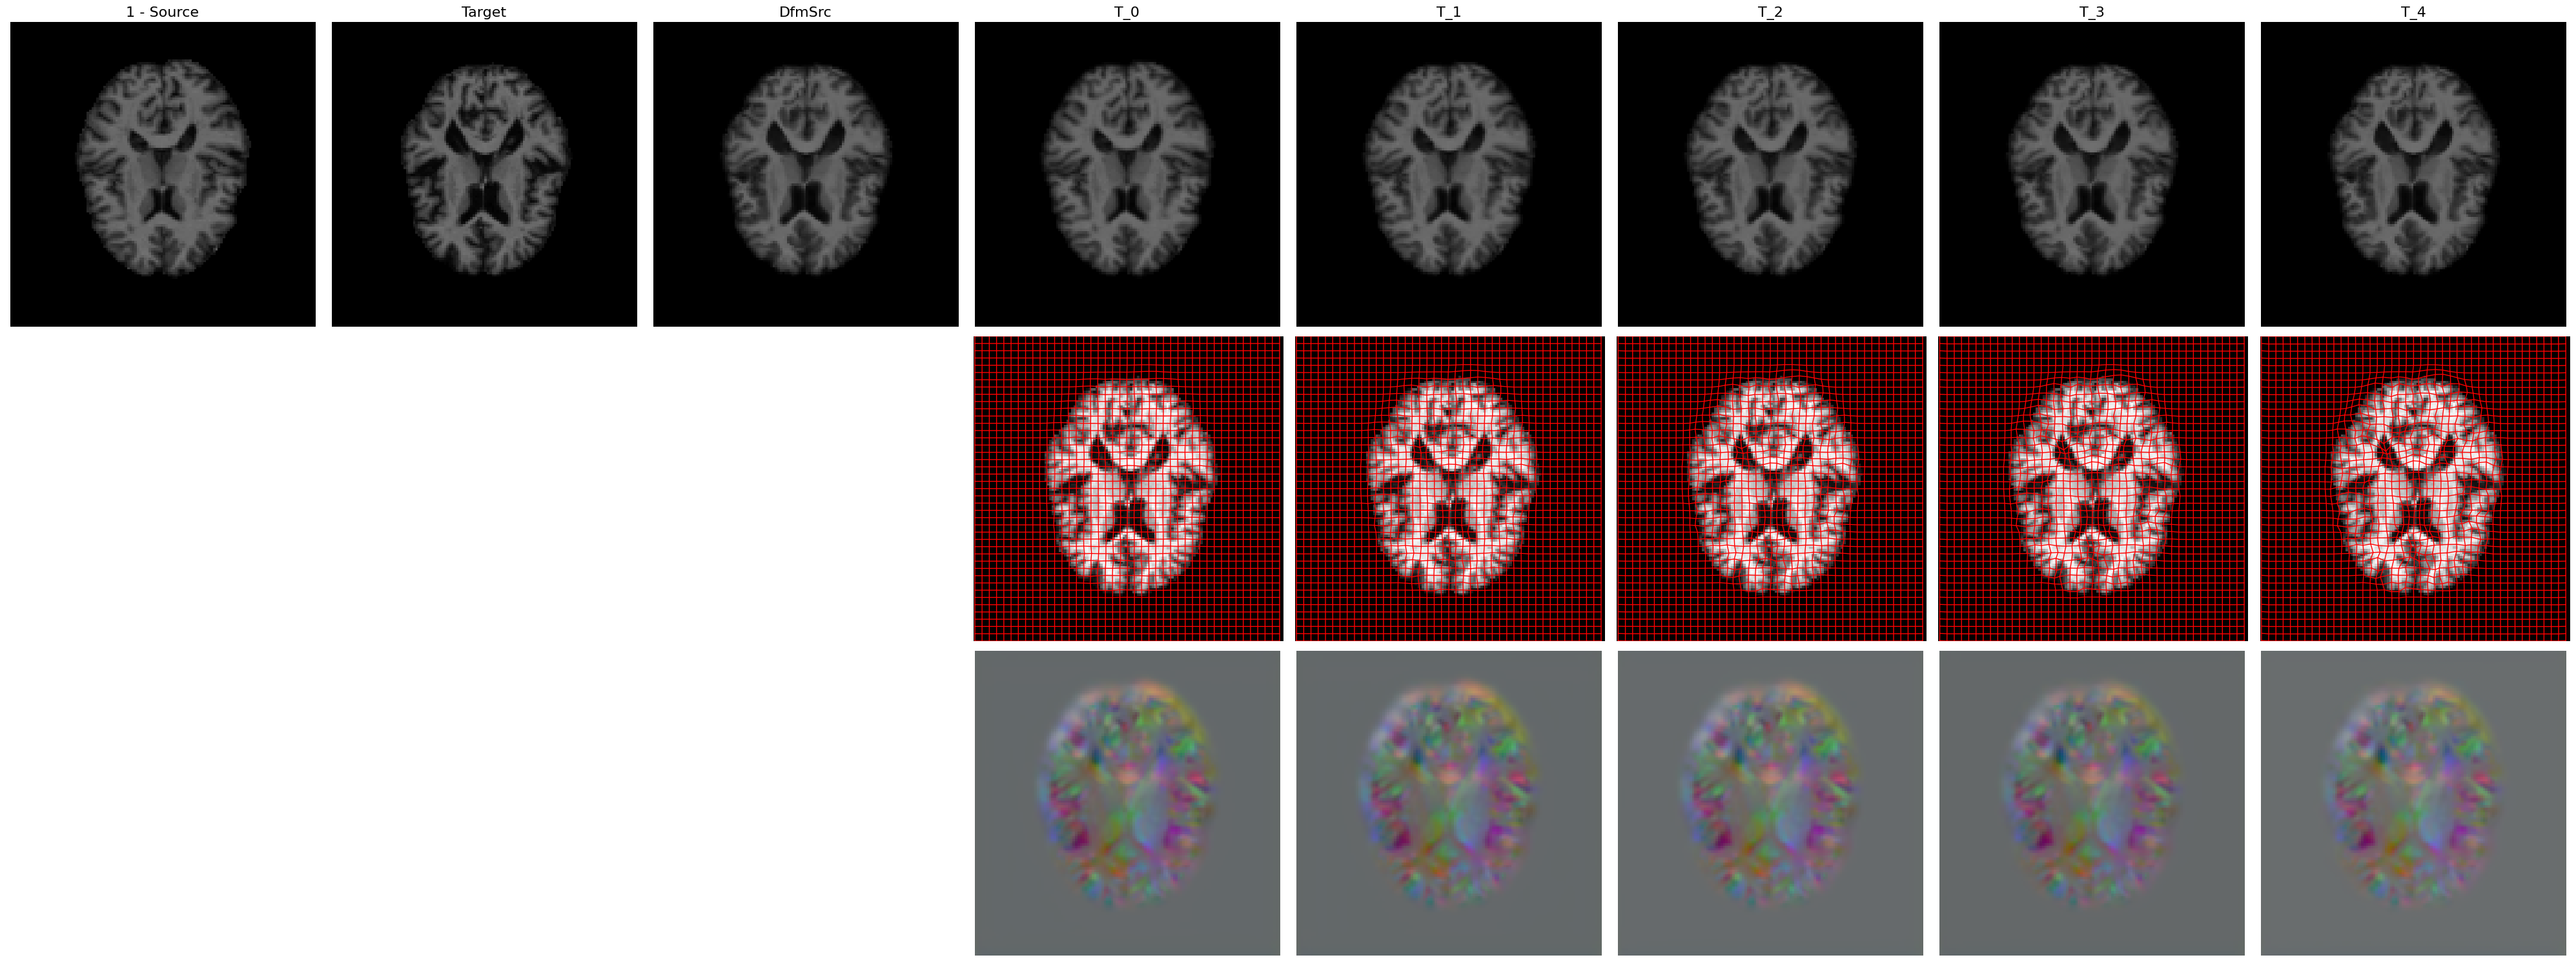

Testing DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.36475682258605957    │
│         test_mse          │  0.00037923635682091117   │
│       test_noploss        │    0.07656069099903107    │
│        test_nopmse        │   0.003252345835790038    │
│        test_noprel        │    0.14986903965473175    │
│         test_reg          │    0.5167285203933716     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.36475682258605957,
  'test_mse': 0.00037923635682091117,
  'test_reg': 0.5167285203933716,
  'test_noprel': 0.14986903965473175,
  'test_nopmse': 0.003252345835790038,
  'test_noploss': 0.07656069099903107}]

: 

In [ ]:
seed_everything(args.seed)
trainer.test(model, data)